# Cancer Detection using Neural Networks: An Easy Tutorial
## Introduction

Deep learning and neural networks have produced strong results for challenging computer vision tasks such as image classification and dcmect detection [cite], and it is easier than ever to get started with deep learning with just a rudimentary knowledge of Python thanks to libraries such as PyTorch. Of course, the applications of deep learning are not just limited to basic natural image tasks; many other fields have benefited from neural networks, such as the key application area of *medical imaging and computer-assisted diagnosis*. In this tutorial, I will show how to use deep learning for a medical imaging classification task on a real dataset of breast cancer MR (magnetic resonance) scans, from start to finish using Python. 

All code can be found at [github.com/mazurowski-lab/MRI-deeplearning-tutorial](https://github.com/mazurowski-lab/MRI-deeplearning-tutorial). This code is partially based on the [code](https://github.com/mazurowski-lab/radiologyintrinsicmanifolds) from my MICCAI 2022 paper "The Intrinsic Manifolds of Radiological Images and their Role in Deep Learning", another example of how I've studied deep learning on medical images.

To begin, I will introduce the standard data type of medical images, DICOM (Digital Imaging and Communications in Medicine) files, and show how to use Python to interact with the breast MRI DICOM data. Next, I will describe how to use PyTorch to create a neural network for image classification, and create a model training and evaluation pipeline that uses this data. In summary, I will provide code that can load the raw breast MRI data, build and train an image classification neural network on it, and evaluate the network on a task of detecting the presence of cancer in new MR images.

# Part 0: Setup
## Requirements
You will need the following libraries installed for Python 3:
1. PyTorch (`torch` and `torchvision`) (see [here](https://pytorch.org/get-started/locally/))
2. `pandas`
3. `numpy`
4. `scikit-image`
5. `pydicom`
6. `tqdm`

# Part I: Preparing The Data
## (1) Download the data

For this tutorial we will use my lab's Duke-Breast-Cancer-MRI (DBC-MRI) dataset, a dataset of breast MR scans from 922 subjects at Duke University (see the paper [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6134102/) for more information). We will be using about one tenth of the full dataset, due to its large size. The first step is to download the data, which can be obtained from The Cancer Imaging Archive (TCIA). Please refer to the following instructions to do this.
1. Travel to the TCIA homepage of DBC-MRI [here](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70226903), and scroll down to the "**Data Access**" tab. 
2. Download the data annotation (breast tumor bounding boxes) and filepath list files "File Path mapping tables (XLSX, 49.6 MB)" and "Annotation Boxes (XLSX, 49 kB)" from the second and fourth rows of the table, respectively. You'll then need to convert these to `.csv` manually (e.g. using Microsoft Excel). Move these into your working directory.
3. In the first row of the table, go to the column "**Download all or Query/Filter**", and click the "**Search**" button to go to a page where you can select a subset of the dataset for download.
4. Skip any tutorial prompts here. Next, make sure you're under the "Search Results" tab, and scroll to the bottom of this table and modify "Show {} entries" to show 100 entries. Your screen should look something like this:
![TCIA data selection screenshot.](imgs/screenshot_TCIA.png)
5. Next, click the shopping cart icon between "**Cart**" and "**Collection ID**" on the table header to select all 100 entries.
6. With the data selected and added to your cart, click the "Cart" tab on the top right of the page (it should also say "36 GB") to go to your cart.
7. Now on the cart page, click "Download" right below the "Cart" tab to download a `.tcia` file that will be used to download your data. You can now close the page.
8. In order to download the dataset (subset) to your computer with the `.tcia` file, you'll need to use TCIA's NBIA Data Retreiver tool, which can be obtained [here](https://wiki.cancerimagingarchive.net/display/NBIA/Downloading+TCIA+Images). Once installed (see the Data Retreiver page for more details), open the downloaded `.tcia` file with the data retreiver tool.
9. Download all files, and **make sure that you download them with the "Classic Directory Name" directory type convention**, otherwise the following data preprocessing code will not work. This will take some time; if the downloads ever halt, resume by performing the same start procedure (the data retreiver program will detect which files have already been downloaded.)
10. Once completed, all DICOM files will be in a folder named `manifest-xxx`, where `xxx` is some string. This manifest folder may be within a few subfolders. Move this manifest folder into your working directory.
11. Proceed to the following section to see how we will process this data for usage with a neural network.

## (2) Process the data for training
To start working with the data, let's begin by importing a few libraries into your Python environment (`.py` script, `.ipynb` notebook, etc.):

In [2]:
import pandas as pd
import numpy as np
import os
import pydicom
from tqdm import tqdm
from skimage.io import imsave

Next, let's begin by defining a few useful filepaths:

In [3]:
data_path = 'manifest-1655917758874'
boxes_path = 'Annotation_Boxes.csv'
mapping_path = 'Breast-Cancer-MRI-filepath_filename-mapping.csv'
target_png_dir = 'png_out'
if not os.path.exists(target_png_dir):
	os.makedirs(target_png_dir)


Here, `data_path` needs be changed to the name string of your downloaded manifest folder (`manifest-xxx`). The variable `boxes_path` is the path of the file containing cancer annotation bounding boxes, `mapping_path` is the path of the file that lists where each image is located, and target_png_dir is the new directory that will be created where we will output `.png` images files extracted from the DICOMs.

Next, let's load the bounding box annotation list and see what it looks like:

In [4]:
boxes_df = pd.read_csv(boxes_path)
display(boxes_df)

,Patient ID,Start Row,End Row,Start Column,End Column,Start Slice,End Slice
0,Breast_MRI_001,234,271,308,341,89,112
1,Breast_MRI_002,251,294,108,136,59,72
2,Breast_MRI_003,351,412,82,139,96,108
3,Breast_MRI_004,262,280,193,204,86,95
4,Breast_MRI_005,188,213,138,178,76,122
...,...,...,...,...,...,...,...
917,Breast_MRI_918,345,395,338,395,62,85
918,Breast_MRI_919,285,312,369,397,98,109
919,Breast_MRI_920,172,193,337,355,87,101
920,Breast_MRI_921,328,374,404,446,97,121


Note that these MRIs are three-dimensional: they have coordinates of height (measured by pixel rows), width (measured pixel columns), and depth (measured by the "slice" dimension). Here, **Start Row**, **End Row**, **Start Column** and **End Column** define the two-dimensional bounding box areas along the height-width pixel dimension where a tumor was found for each patient, while **Start Slice** and **End Slice** describe how far the bounding box/tumor extends in the depth (slice) dimension.

For simplicity, we will only consider fat-saturated MR exams: this can be accomplished by loading the image filepath `.csv` list, and only keeping the subset of fat-saturated images:

In [5]:
# only consider fat-satured "pre" exams
mapping_df = pd.read_csv(mapping_path)
mapping_df = mapping_df[mapping_df['original_path_and_filename'].str.contains('pre')]

# remove entries from patients that we are not including (we only include patients 1 to 100)
# using a regex pattern
crossref_pattern = '|'.join(["DICOM_Images/Breast_MRI_{:03d}".format(s) for s in list(range(1, 101))])
mapping_df = mapping_df[mapping_df['original_path_and_filename'].str.contains(crossref_pattern)]

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Note that each row in `mapping_df` refers to a different 2D slice of a full 3D MRI *volume*.

Next, we are ready to write some code to automatically extract `.png` files from the raw DICOM data, as `.png` work nicely with PyTorch (and take up much less space than DICOMs). First, however, we need to *define our classification task*, as the labels that we will assign to each extracted `.png` image are based off of this task definition. 

### Defining our task
A straightforward task is simply to train a classification model to detect for the presence of cancer within breast MRI slices; by convention, we will take all 2D slices that contain a tumor bounding box to have cancer (labeled as **positive**, or **1**), and all other slices at least five slices away from positive slices to be **negative**, or **0**.

Before we write our `.png` extraction code, we will need to write a helper function for saving a single 2D slice `.png` image of a 3D MRI (each DICOM file contains a single slice). This function, which we will name `save_dcm_slice()`, will take three arguments: 
1. `dcm_fname`, the filename of the source DICOM,
2. `label`, the cancer label of that slice, either `0` for negative or `1` for positive, and
3. `vol_idx`, the patient number/index of the MRI out of the entire dataset.

This function can be written with the following code, which I comment to explain each step (including some additional necessary preprocessing)

In [6]:
def save_dcm_slice(dcm_fname, label, vol_idx):
    # create a path to save the slice .png file in, according to the original DICOM filename and target label
    png_path = dcm_fname.split('/')[-1].replace('.dcm', '-{}.png'.format(vol_idx))
    label_dir = 'pos' if label == 1 else 'neg'
    png_path = os.path.join(target_png_dir, label_dir, png_path)

    if not os.path.exists(os.path.join(target_png_dir, label_dir)):
        os.makedirs(os.path.join(target_png_dir, label_dir))
    
    if not os.path.exists(png_path):
        # only make the png image if it doesn't already exist (if you're running this after the first time)
        
        # load DICOM file with pydicom library
        try:
            dcm = pydicom.dcmread(dcm_fname)
        except FileNotFoundError:
            # fix possible errors in filename from list
            dcm_fname_split = dcm_fname.split('/')
            dcm_fname_end = dcm_fname_split[-1]
            assert dcm_fname_end.split('-')[1][0] == '0'
            
            dcm_fname_end_split = dcm_fname_end.split('-')
            dcm_fname_end = '-'.join([dcm_fname_end_split[0], dcm_fname_end_split[1][1:]])
            
            dcm_fname_split[-1] = dcm_fname_end
            dcm_fname = '/'.join(dcm_fname_split)
            dcm = pydicom.dcmread(dcm_fname)
            
        
        # convert DICOM into numerical numpy array of pixel intensity values
        img = dcm.pixel_array

        # convert uint16 datatype to float, scaled properly for uint8
        img = img.astype(np.float) * 255. / img.max()
        # convert from float -> uint8
        img = img.astype(np.uint8)
        # invert image if necessary, according to DICOM metadata
        img_type = dcm.PhotometricInterpretation
        if img_type == "MONOCHROME1":
            img = np.invert(img)

        # save final .png
        imsave(png_path, img)

Next, when converting each 2D slice to a `.png`, we'll want to iterate over each 3D patient volume, as each volume is associated with a single breast tumor bounding box, as is all 2D slices (DICOMs) within that volume. 

It is also important that the network is trained on a dataset that has a balanced amount of positive and negative class examples, so that it doesn't focus too heavily on one of the two classes (see our paper [here](https://www.sciencedirect.com/science/article/pii/S0893608018302107) for further discussion on the class imbalance problem). In total, we could extract a bit more than 2600 positive images from this dataset, and about 13500 negatives. As such, to maintain a class balance, we will extract exactly 2600 of each class.

This can be accomplished with the following code that iterates through `mapping_df` (the conversion will take some time):

In [7]:
# number of examples for each class
N_class = 2600
# counts of examples extracted from each class
ct_negative = 0
ct_positive = 0

# initialize iteration index of each patient volume
vol_idx = -1
for row_idx, row in tqdm(mapping_df.iterrows(), total=N_class*2):
	# indices start at 1 here
	new_vol_idx = int((row['original_path_and_filename'].split('/')[1]).split('_')[-1])
	slice_idx = int(((row['original_path_and_filename'].split('/')[-1]).split('_')[-1]).replace('.dcm', ''))

	# new volume: get tumor bounding box
	if new_vol_idx != vol_idx:
		box_row = boxes_df.iloc[[new_vol_idx-1]]
		start_slice = int(box_row['Start Slice'])
		end_slice = int(box_row['End Slice'])
		assert end_slice >= start_slice
	vol_idx = new_vol_idx

	# get DICOM filename
	dcm_fname = str(row['classic_path'])
	dcm_fname = os.path.join(data_path, dcm_fname)
	
	# determine slice label:
	# (1) if within 3D box, save as positive
	if slice_idx >= start_slice and slice_idx < end_slice: 
		if ct_positive >= N_class:
			continue
		# dcm = load_dcm(dcm_fname)
		save_dcm_slice(dcm_fname, 1, vol_idx)
		ct_positive += 1

	# (2) if outside 3D box by >5 slices, save as negative
	elif (slice_idx + 5) <= start_slice or (slice_idx - 5) > end_slice:
		if ct_negative >= N_class:
			continue
		save_dcm_slice(dcm_fname, 0, vol_idx)
		ct_negative += 1

17116it [00:01, 11328.50it/s]                        


### 

Now let's see what one of these images looks like. We'll display a random positive (cancer) image (ran in a Jupyter notebook):

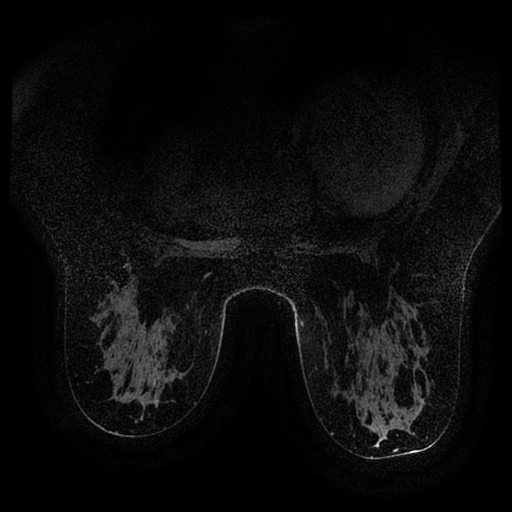

In [15]:
from IPython.display import Image, display
from random import choice

positive_image_dir = os.path.join(target_png_dir, 'pos')
negative_image_filenames = os.listdir(positive_image_dir)
sample_image_path = os.path.join(positive_image_dir, choice(negative_image_filenames))

display(Image(filename=sample_image_path))





That's it for this tutorial! We are now ready to train and test a neural network to detect the presence of cancer with this data. Please proceed to the following tutorial, where I show (1) how to create a PyTorch data loading pipeline for network training and evaluation and (2) how to load, train and test a classification network with this data.

# Part II: Training a  Classification Model

## (1) Building a data loading pipeline

Deep learning is data-driven, so having a reliable framework to work with (image) data is essential. PyTorch (the `torch` and `torchvision` libraries in Python), among other things, allows for the efficient manipulation and management of numerical matrices, and is one of the most popular deep learning frameworks (as neural networks operate and learn via many matrix multiplications and additions). Images can also be describes with large matrices of numbers, where the dimensions of the matrices correspond to the size of the image, and each element of the matrix is a pixel intensity value. As such, it is extremely helpful to abstract all image data loading/processing and neural networks operations with PyTorch, which comes with myriad convenient modules and tools for these and more.

The central objects that we will use are the `Dataset` and `DataLoader` of `torch.utils.data`. While `Dataset` allows for the easy storage and indexing of data samples and labels, `DataLoader` makes it possible to easily access these samples in a way that integrates very well with how we will train and test neural networks. Please see PyTorch's [tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information. To start, lets import the needed libaries and objects:

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.io import imread

Next, let's define some constants:

In [17]:
# directory where our .png data is (outputted from the previous part)
data_dir = 'png_out'
# length in pixels of size of image once resized for the network
img_size = 128 

### Datasets


First, we must define our own `Dataset` for the DBC dataset, called `DBCDataset`. In summary, the important methods defined in `DBCDataset` are:
1. the `create_labels()` method assigns an easily-accessible label to each image in the dataset, 
2. the `normalize()` method normalizes images to the pixel value range `[0,255]`, as it's important to standardize data for deep learning, 
3. the `__getitem__()` method is required for `Dataset`s, and describes how data is obtained from the dataset with an index (or indices)

Check out the code block below, where I've added comments to explain each step.  

In [18]:
class DBCDataset(Dataset):
    def __init__(self):
        self.data_dir = data_dir
        self.img_size = img_size
        
        # assign labels to data within this Dataset
        self.labels = None
        self.create_labels()

    def create_labels(self):
        # create and store a label (positive/1 or negative/0 for each image)
        # each label is the tuple: (img filename, label number (0 or 1))
        labels = []
        print('building DBC dataset labels.')
        # iterate over each class
        for target, target_label in enumerate(['neg', 'pos']):
            case_dir = os.path.join(self.data_dir, target_label)
            # iterate over all images in the class/case type
            for fname in os.listdir(case_dir):
                if '.png' in fname:
                    fpath = os.path.join(case_dir, fname)
                    labels.append((fpath, target))
            
        self.labels = labels

                 
    def normalize(self, img):
        # normalize image pixel values to range [0, 255]
        # img expected to be array
                 
        # convert uint16 -> float
        img = img.astype(np.float) * 255. / img.max()
        # convert float -> unit8
        img = img.astype(np.uint8)
        
        return img
    
    def __getitem__(self, idx):
        # required method for accessing data samples
        # returns data with its label
        fpath, target  = self.labels[idx]
        
        # load img from file (png or jpg)
        img_arr = imread(fpath, as_gray=True)
        
        # normalize image
        img_arr = self.normalize(img_arr)
        
        # convert to tensor (PyTorch matrix)
        data = torch.from_numpy(img_arr)
        data = data.type(torch.FloatTensor) 
       
        # add image channel dimension (to work with neural network)
        data = torch.unsqueeze(data, 0)
        
        # resize image
        data = transforms.Resize((self.img_size, self.img_size))(data)
        
        return data, target

    def __len__(self):
        # required method for getting size of dataset
        return len(self.labels)

From here we can simply create an instance of the dataset with:

In [20]:
dataset = DBCDataset()

building DBC dataset labels.


### Training, validation and test sets: what are the differences?
To develop our classification model we will need to split our dataset into training, validation, and test sets. For each image in the datapoint, there is an associated label that we want the classification model to predict. But what are the differences between these data subsets?
1. The training set is used to provide the model with examples for how to make predictions; this is what the model "learns" from. The learning algorithm is just modifying the neural network parameters to minimize the average prediction error on the training set.
2. The validation set is used to estimate how well the model performs on predicting labels for new data that it has not learned from (the ultimate goal of developing this model, also known as *generalization*). This validation prediction error is used to select at which point in training we'd like to save the model: we want to save the model when the validation error is lowest. You can also use the validation set to select *hyperparameters* or settings for the training algorithm that are not learned from the training set.
3. The test set, like the validation set, is also used to estimate the *generalization ability* of the neural network on new data; however, this must be separate from the validation set because the validation set itself was used to select the final model, and we want an unbiased estimate of generalization ability


With a dataset size of 2600 + 2600 = 5200, a typical set of percentages for splitting the dataset into training/validation/testing could be something like 80%/10%/10%, which results in a training set of size 4160, and validation and testing set sizes of 520, each. Practically, we can extract these subsets from our dataset with the useful function `torch.utils.data.random_split()`, which randomly splits up the full dataset into subsets:

In [21]:
train_fraction = 0.8
validation_fraction = 0.1
test_fraction = 0.1
dataset_size = len(dataset)
[print(dataset_size)]

num_train = int(train_fraction * dataset_size)
num_validation = int(validation_fraction * dataset_size)
num_test = int(test_fraction * dataset_size)
print(num_train, num_validation, num_test)

#subset_sizes = [train_fraction * dataset_size, validation_fraction * dataset_size, test_fraction * dataset_size]
#subset_sizes = [np.floor(s) for s in subset_sizes]
#print(subset_sizes)

train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [num_train, num_validation, num_test])

5200
4160 520 520


### Dataloaders
We've created PyTorch `Dataset`s for model training, validation and testing, which is most of the work for our data-loading pipeline. To finish, we will need to create PyTorch `Dataloader`s to conveniently access images from our datasets. But first, a quick note on *batch sizes*.

#### Batch sizes and computation devices
While we could train neural networks on one image at a time, this would be prohibitively slow, as they usually require learning from hundreds or thousands of images, many times. Instead, we can train on *batches* of multiple images at the same time, limited by the memory capacity of our computation processing device; for example, GPUs (graphical processing units), which are specially designed for image manipulation.

Below, we will create `Dataloaders` for each of our three data subsets. We will use a batch size of 100 for the training set, but this is very much dependent on the CPU or GPU hardware that you use for computations. To create the most accessible example, we will stick to the CPU. The device that we will load data on to can be specified with:

In [22]:
# GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('running on {}'.format(device))

running on cpu


Now, let's create our dataloaders:


In [31]:
train_batchsize = 100
eval_batchsize = 10
train_loader = DataLoader(train_dataset, 
                                     batch_size=train_batchsize, 
                                     shuffle=True
                                     # images are loaded in random order
                                                )
                                                
validation_loader = DataLoader(validation_dataset, 
                        batch_size=eval_batchsize)

test_loader = DataLoader(test_dataset, 
                        batch_size=eval_batchsize)

Next, to ensure that our results will be reproducible, we will fix all random seeds with:

In [23]:
# set random seeds for reproducibility
import random
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

With this, we are ready to introduce and build our classification neural network!

## (2) Loading a neural network
Neural networks are really just functions with many, many parameters (a.k.a. dials to tune). These parameters are *learned* from lots of data to tune the network to best approximate the function that we're trying to emulate. For example, an image classification neural network, like the one we will work with, is trained to take images as input, and output the correct class identity of the image, e.g., whether a breast image is cancerous. The many successive computational *layers* of neural networks allow them to learn very complicated functions that would be practically impossible to hand-design.

*Convolutional* neural networks were particularly designed to learn to detect the spatial patterns found in images, so are especially well-suited for our task. Today, we will work with a very popular modern neural network architecture called a residual network, or *ResNet* for short. In fact, the original [ResNet paper](https://arxiv.org/abs/1512.03385) is one of the most cited papers of all time, with over 120,000 citations as of June 2022, according to Google Scholar. We will be using a particular version of the ResNet *model* known as ResNet-18, the details of which are beyond the scope of this tutorial. ResNet-18 and models like it can be easily loaded (untrained) with PyTorch's `torchvision.models` library, as:

In [26]:
from torchvision.models import resnet18
from torch import nn

Here we also imported PyTorch's neural network library `torch.nn`. Next, we will load a ResNet-18 to work with (as `resnet18` is a class), and attach it to our set computation `device`, with:

In [25]:
net = resnet18()
net = net.to(device)

ResNets are designed to work with color, three-channel images. However, our MRI slices are one-channel, so we will need to modify our `net` to take one-channel inputs. This can be accomplished by modifying the *input layer* of `net` as:

In [27]:
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

With that, our network is ready to be trained to classify our images. Let's set up a training pipeline!

## (3) Setting up for training
Neural networks "learn" by minimizing the average error of making predictions on the entire training set. Each iteration, or *epoch*, over the training set, the parameters are adjusted in order to perform better at the next iteration. The change for each parameter is determined by the *backpropagation* algorithm, which adjusts each parameter to make the steepest decrease in error at the given iteration, over average (this process is known as *stochastic gradient descent* or "SGD").

There are a couple of things that we will need to define in order to make this happen. First, we must define this prediction error, also known as *loss*. For the task of classification, the loss that we need is `nn.CrossEntropyLoss()`, which increases as the network predicts more incorrect classification of images in the training set. This is what we want to minimize in training; we can define it as:

In [28]:
loss = nn.CrossEntropyLoss()

Next, we want to define the *error minimization* algorithm that we will use; again, this *is stochastic gradient descent*, or SGD; there are others of course, but SGD is the most basic and will serve fine. When creating an instance of SGD, we will need to tell it which parameters we will minimize (the parameters of `net`, and the *learning rate*. The learning rate (`lr`) is a fixed constant, that basically determines the approximate size of adjustments made to parameters during learning. A good choice of learning rate can vary depending on the task, data, network and other factors, but for now, we will choose `lr=0.001`.

In [29]:
error_minimizer = torch.optim.SGD(net.parameters(), lr=0.001)

Finall, let's set the number of training epochs (passes over the entire training set) to 100:


In [30]:
epochs = 100


## (4) Train and validate your model!


*Note*: rather than saving model at best validation, just copy model and store as a separate var.


## (5) Testing your best model

```

```